# Implementing Recommender Systems - Lab

## Introduction

In this lab, you'll practice creating a recommender system model using `surprise`. You'll also get the chance to create a more complete recommender system pipeline to obtain the top recommendations for a specific user.


## Objectives

In this lab you will: 

- Use surprise's built-in reader class to process data to work with recommender algorithms 
- Obtain a prediction for a specific user for a particular item 
- Introduce a new user with rating to a rating matrix and make recommendations for them 
- Create a function that will return the top n recommendations for a user 


For this lab, we will be using the famous 1M movie dataset. It contains a collection of user ratings for many different movies. In the last lesson, you were exposed to working with `surprise` datasets. In this lab, you will also go through the process of reading in a dataset into the `surprise` dataset format. To begin with, load the dataset into a Pandas DataFrame. Determine which columns are necessary for your recommendation system and drop any extraneous ones.

In [1]:
import pandas as pd
df = pd.read_csv('./ml-latest-small/ratings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [2]:
# Drop unnecessary columns
new_df = df.drop(columns=['timestamp'])

It's now time to transform the dataset into something compatible with `surprise`. In order to do this, you're going to need `Reader` and `Dataset` classes. There's a method in `Dataset` specifically for loading dataframes.

In [6]:
from surprise import Reader, Dataset
# read in values as Surprise dataset 
reader = Reader()
data = Dataset.load_from_df(new_df, reader)

In [5]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 364 kB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp38-cp38-linux_x86_64.whl size=2325222 sha256=48b96984c595fe8e68d52ded6748d0f2ffad7ec1d1f13f50616c36620b495b8a
  Stored in directory: /home/jovyan/.cache/pip/wheels/20/91/57/2965d4cff1b8ac7ed1b6fa25741882af3974b54a31759e10b6
Successfully built scikit-surprise


Let's look at how many users and items we have in our dataset. If using neighborhood-based methods, this will help us determine whether or not we should perform user-user or item-item similarity

In [7]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


## Determine the best model 

Now, compare the different models and see which ones perform best. For consistency sake, use RMSE to evaluate models. Remember to cross-validate! Can you get a model with a higher average RMSE on test data than 0.869?

In [9]:
# importing relevant libraries
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np

In [ ]:
SVD()

In [18]:
## Perform a gridsearch with SVD
# ⏰ This cell may take several minutes to run
param_grid = {'n_factors':[20, 50, 100],'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005],
               'reg_all': [0.02, 0.05, 0.1, 0.2]}
gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
gs_model.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.7min finished


In [19]:
# print out optimal parameters for SVD after GridSearch
print(gs_model.best_score)
print(gs_model.best_params)

{'rmse': 0.8699410708483258, 'mae': 0.668553692113774}
{'rmse': {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.05}, 'mae': {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.05}}


In [ ]:
KNNBasic()

In [14]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [15]:
# print out the average RMSE score for the test set
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.97334356, 0.96541415, 0.98028026, 0.98357524, 0.96070664]))
('test_mae', array([0.75469675, 0.74557589, 0.75572886, 0.75665809, 0.74075089]))
('fit_time', (1.2530522346496582, 1.2825167179107666, 1.2832205295562744, 1.1960604190826416, 1.1243846416473389))
('test_time', (3.861839532852173, 3.772829532623291, 3.7201569080352783, 3.7391834259033203, 3.701141595840454))
-----------------------
0.9726639699406695


In [16]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [17]:
# print out the average score for the test set
for i in cv_knn_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.88332334, 0.87943793, 0.87746649, 0.88055041, 0.86690691]))
('test_mae', array([0.67444495, 0.67253422, 0.67051531, 0.67087892, 0.66361455]))
('fit_time', (1.142209768295288, 1.1300358772277832, 1.2556829452514648, 1.130403757095337, 1.1362769603729248))
('test_time', (3.958263874053955, 4.123708486557007, 4.080893039703369, 4.131479978561401, 4.134448528289795))
-----------------------
0.8775370154205995


In [29]:
param_grid = {'k':[20,30,40],'min_k': [1, 2, 5],
               'sim_options': {'user_based':[True]}}
gs_model = GridSearchCV(KNNBaseline,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
gs_model.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  3.4min remaining:   25.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.7min finished


Based off these outputs, it seems like the best performing model is the SVD model with `n_factors = 50` and a regularization rate of 0.05. Use that model or if you found one that performs better, feel free to use that to make some predictions.

## Making Recommendations

It's important that the output for the recommendation is interpretable to people. Rather than returning the `movie_id` values, it would be far more valuable to return the actual title of the movie. As a first step, let's read in the movies to a dataframe and take a peek at what information we have about them.

In [20]:
df_movies = pd.read_csv('./ml-latest-small/movies.csv')

In [21]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Making simple predictions
Just as a reminder, let's look at how you make a prediction for an individual user and item. First, we'll fit the SVD model we had from before.

In [20]:
svd = SVD(n_factors= 50, reg_all=0.05)
svd.fit(dataset)

In [21]:
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=3.0129484092252135, details={'was_impossible': False})

This prediction value is a tuple and each of the values within it can be accessed by way of indexing. Now let's put our knowledge of recommendation systems to do something interesting: making predictions for a new user!

## Obtaining User Ratings 

It's great that we have working models and everything, but wouldn't it be nice to get to recommendations specifically tailored to your preferences? That's what we'll be doing now. The first step is to create a function that allows us to pick randomly selected movies. The function should present users with a movie and ask them to rate it. If they have not seen the movie, they should be able to skip rating it. 

The function `movie_rater()` should take as parameters: 

* `movie_df`: DataFrame - a dataframe containing the movie ids, name of movie, and genres
* `num`: int - number of ratings
* `genre`: string - a specific genre from which to draw movies

The function returns:
* rating_list : list - a collection of dictionaries in the format of {'userId': int , 'movieId': int , 'rating': float}

#### This function is optional, but fun :) 

<AxesSubplot:>

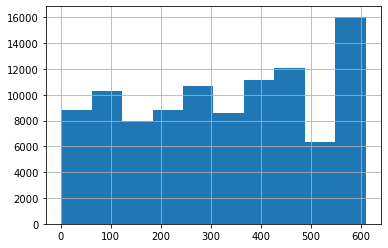

In [31]:
new_df.userId.hist()

In [32]:
# The above shows us that different users have rated different numbers of times throughout the dataset, and that the
# largest ID is around 600, meaning we can use a higher number for a new user.

In [79]:
all([True, True])

True

In [106]:
def movie_rater(movie_df,num, genre=None):
    
    rating_list = []
    genres = genre.split('|')
    print(genres)
    genre_df = movie_df[movie_df.genres.map(lambda x: all([gen in x.split('|') for gen in genres]))]
    Ids = []
    
    for i in range(num):
        
        info = {}
        res = None
        info['userId'] = 1000
        
        while res is None:
            
            while True:
                sample = genre_df.sample(1)
                Id = sample.iloc[0].movieId
                if Id not in Ids:
                    break
            print(sample)
            res = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :')
            
            try:
                res = int(res)
            except:
                res = res
    
            if type(res) == str:
                if res.lower() == 'n':
                    res = None
                    continue
                else:
                    print('Invalid Input')
                    res = None
                    continue
            elif res not in range(1,6):
                print('Invalid Input')
                res = None
                
        Ids.append(Id)
        info['movieId'] = Id
        info['rating'] = res
        rating_list.append(info)
        
    return rating_list

In [107]:
df_movies.genres.unique()

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance',
       'Comedy|Drama|Romance', 'Comedy', 'Action|Crime|Thriller',
       'Adventure|Children', 'Action', 'Action|Adventure|Thriller',
       'Comedy|Horror', 'Adventure|Animation|Children', 'Drama',
       'Action|Adventure|Romance', 'Crime|Drama', 'Drama|Romance',
       'Action|Comedy|Crime|Drama|Thriller', 'Comedy|Crime|Thriller',
       'Crime|Drama|Horror|Mystery|Thriller', 'Drama|Sci-Fi',
       'Children|Drama', 'Adventure|Drama|Fantasy|Mystery|Sci-Fi',
       'Mystery|Sci-Fi|Thriller', 'Children|Comedy', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure|Fantasy',
       'Comedy|Drama|Thriller', 'Mystery|Thriller',
       'Animation|Children|Drama|Musical|Romance',
       'Crime|Mystery|Thriller', 'Adventure|Drama', 'Drama|Thriller',
       'Comedy|Crime', 'Action|Sci-Fi|Thriller',
       'Action|Comedy|Horror|Thriller', 'Comedy|Drama', 'Documentary',
       'Ac

In [108]:
user_ratings = movie_rater(df_movies, 10, 'Action|Adventure')

['Action', 'Adventure']
      movieId                     title                    genres
2126     2826  13th Warrior, The (1999)  Action|Adventure|Fantasy
How do you rate this movie on a scale of 1-5, press n if you have not seen :5
      movieId                       title                    genres
3662     5040  Conan the Destroyer (1984)  Action|Adventure|Fantasy
How do you rate this movie on a scale of 1-5, press n if you have not seen :4
      movieId                                       title  \
1058     1375  Star Trek III: The Search for Spock (1984)   

                       genres  
1058  Action|Adventure|Sci-Fi  
How do you rate this movie on a scale of 1-5, press n if you have not seen :4
      movieId                           title                     genres
6199    45186  Mission: Impossible III (2006)  Action|Adventure|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :4
      movieId                                      title  \
601

In [37]:
# try out the new function here!

      movieId                   title          genres
6579    55245  Good Luck Chuck (2007)  Comedy|Romance
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId                       title          genres
1873     2491  Simply Irresistible (1999)  Comedy|Romance
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId                  title  genres
3459     4718  American Pie 2 (2001)  Comedy
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId             title                   genres
4160     5990  Pinocchio (2002)  Children|Comedy|Fantasy
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3


If you're struggling to come up with the above function, you can use this list of user ratings to complete the next segment

In [38]:
user_rating

[{'userId': 1000, 'movieId': 55245, 'rating': '5'},
 {'userId': 1000, 'movieId': 2491, 'rating': '4'},
 {'userId': 1000, 'movieId': 4718, 'rating': '4'},
 {'userId': 1000, 'movieId': 5990, 'rating': '3'}]

In [109]:
user_ratings 

[{'userId': 1000, 'movieId': 2826, 'rating': 5},
 {'userId': 1000, 'movieId': 5040, 'rating': 4},
 {'userId': 1000, 'movieId': 1375, 'rating': 4},
 {'userId': 1000, 'movieId': 45186, 'rating': 4},
 {'userId': 1000, 'movieId': 37830, 'rating': 2},
 {'userId': 1000, 'movieId': 65982, 'rating': 4},
 {'userId': 1000, 'movieId': 6156, 'rating': 4},
 {'userId': 1000, 'movieId': 3153, 'rating': 3},
 {'userId': 1000, 'movieId': 91529, 'rating': 5},
 {'userId': 1000, 'movieId': 5479, 'rating': 5}]

### Making Predictions With the New Ratings
Now that you have new ratings, you can use them to make predictions for this new user. The proper way this should work is:

* add the new ratings to the original ratings DataFrame, read into a `surprise` dataset 
* train a model using the new combined DataFrame
* make predictions for the user
* order those predictions from highest rated to lowest rated
* return the top n recommendations with the text of the actual movie (rather than just the index number) 

In [110]:
## add the new ratings to the original ratings DataFrame
print(len(new_df))

100836


In [112]:
pd.DataFrame(user_ratings)

,userId,movieId,rating
0,1000,2826,5
1,1000,5040,4
2,1000,1375,4
3,1000,45186,4
4,1000,37830,2
5,1000,65982,4
6,1000,6156,4
7,1000,3153,3
8,1000,91529,5
9,1000,5479,5


In [113]:
joined_df = pd.concat([new_df, pd.DataFrame(user_ratings)])
len(joined_df)

100846

In [114]:
# train a model using the new combined DataFrame
svd = SVD(n_factors= 50, reg_all=0.05)
svd.fit(dataset)

In [119]:
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
predicted_ratings = []

for Id in df_movies.movieId:
    prediction = svd.predict(1000, Id)
    info = (Id, prediction[3])
    predicted_ratings.append(info)

In [120]:
predicted_ratings[:5]

[(1, 3.916053826754517),
 (2, 3.519509030281736),
 (3, 3.266767851876666),
 (4, 3.0071057492764894),
 (5, 3.013377246954914)]

In [125]:
predicted_ratings.sort(key = lambda x: x[1])

In [130]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(predicted_ratings, key = lambda x: x[1], reverse=True)

In [131]:
ranked_movies[:5]

[(318, 4.373759453968166),
 (750, 4.345095959695067),
 (1204, 4.339140068833194),
 (1104, 4.299335865235347),
 (904, 4.283461471369231)]

 For the final component of this challenge, it could be useful to create a function `recommended_movies()` that takes in the parameters:
* `user_ratings`: list - list of tuples formulated as (user_id, movie_id) (should be in order of best to worst for this individual)
* `movie_title_df`: DataFrame 
* `n`: int - number of recommended movies 

The function should use a `for` loop to print out each recommended *n* movies in order from best to worst

In [134]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
    
    sorted_ratings = sorted(user_ratings, key = lambda x: x[1], reverse=True)
    
    for i in range(n):
        print('Recommendation # {} : '.format(i+1), movie_title_df.set_index('movieId').loc[sorted_ratings[i][0]].title)
            
recommended_movies(ranked_movies,df_movies,5)

Recommendation # 1 :  Shawshank Redemption, The (1994)
Recommendation # 2 :  Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Recommendation # 3 :  Lawrence of Arabia (1962)
Recommendation # 4 :  Streetcar Named Desire, A (1951)
Recommendation # 5 :  Rear Window (1954)


## Level Up (Optional)

* Try and chain all of the steps together into one function that asks users for ratings for a certain number of movies, then all of the above steps are performed to return the top $n$ recommendations
* Make a recommender system that only returns items that come from a specified genre

## Summary

In this lab, you got the chance to implement a collaborative filtering model as well as retrieve recommendations from that model. You also got the opportunity to add your own recommendations to the system to get new recommendations for yourself! Next, you will learn how to use Spark to make recommender systems.